In [1]:
#Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
# Load both train and test datasets
train_dataset = pd.read_csv("train_data.csv")
test_dataset = pd.read_csv("test_data.csv")

In [3]:
#Check dataset
print("Train Dataset columns:", train_dataset.columns)
print("Test Dataset columns:", test_dataset.columns)

Train Dataset columns: Index(['event_id', 'time_to_tca', 'mission_id', 'risk', 'max_risk_estimate',
       'max_risk_scaling', 'miss_distance', 'relative_speed',
       'relative_position_r', 'relative_position_t',
       ...
       't_sigma_rdot', 'c_sigma_rdot', 't_sigma_tdot', 'c_sigma_tdot',
       't_sigma_ndot', 'c_sigma_ndot', 'F10', 'F3M', 'SSN', 'AP'],
      dtype='object', length=103)
Test Dataset columns: Index(['event_id', 'time_to_tca', 'mission_id', 'risk', 'max_risk_estimate',
       'max_risk_scaling', 'miss_distance', 'relative_speed',
       'relative_position_r', 'relative_position_t',
       ...
       't_sigma_rdot', 'c_sigma_rdot', 't_sigma_tdot', 'c_sigma_tdot',
       't_sigma_ndot', 'c_sigma_ndot', 'F10', 'F3M', 'SSN', 'AP'],
      dtype='object', length=103)


In [4]:
# Replace 'UNKNOWN' with NaN
train_dataset.replace('UNKNOWN', np.nan, inplace=True)
test_dataset.replace('UNKNOWN', np.nan, inplace=True)


In [5]:
#Data Preprocessing
#--------------------------------------------

# Remove unnecessary columns
drop_columns = ['event_id', 'mission_id', 'c_object_type']
train_dataset.drop(columns=[col for col in drop_columns if col in train_dataset.columns], inplace=True)
test_dataset.drop(columns=[col for col in drop_columns if col in test_dataset.columns], inplace=True)

# Make every column numeric
train_dataset = train_dataset.apply(pd.to_numeric, errors='coerce')
test_dataset = test_dataset.apply(pd.to_numeric, errors='coerce')

# Replace all inf values
train_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
test_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Use the median to fill in the missing values
train_dataset.fillna(train_dataset.median(numeric_only=True), inplace=True)
test_dataset.fillna(test_dataset.median(numeric_only=True), inplace=True)

In [6]:
#Target Labels Creation & Balancing

# Binary label
train_dataset['target'] = (train_dataset['risk'] > -10).astype(int)
test_dataset['target'] = (test_dataset['risk'] > -10).astype(int)

# Balance the dataset
class_0 = train_dataset[train_dataset['target'] == 0]
class_1 = train_dataset[train_dataset['target'] == 1]
train_dataset_balanced = pd.concat([class_0.sample(n=len(class_1), random_state=42), class_1], axis=0)

In [7]:
#Feature Selection & Standardization

X_train = train_dataset_balanced.drop(columns=['risk', 'target'])
y_train = train_dataset_balanced['target']
X_test = test_dataset.drop(columns=['risk', 'target'])
y_test = test_dataset['target']


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#SVM Model Training & Prediction



# Create SVM model
space_svm_model = SVC(kernel='rbf', probability=True, random_state=42)
space_svm_model.fit(X_train_scaled, y_train)

# Predict on test data
y_predict_svm = space_svm_model.predict(X_test_scaled)

In [9]:
# Accuracy
accuracy_svm_model = accuracy_score(y_test, y_predict_svm)
print(f"[SVM] Accuracy: {accuracy_svm_model * 100:.2f}%")

[SVM] Accuracy: 76.11%



Support Vector Machine (SVM) Algorithm:
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      2228
           1       0.67      0.76      0.71      1431

    accuracy                           0.76      3659
   macro avg       0.75      0.76      0.75      3659
weighted avg       0.77      0.76      0.76      3659


Confusion Matrix for SVM:
[[1698  530]
 [ 344 1087]]
[SVM] ROC-AUC Score: 0.85


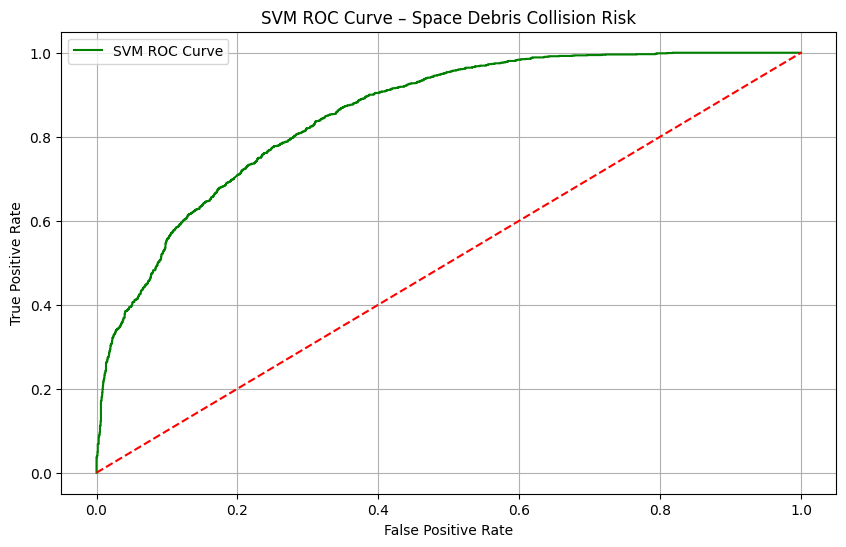

In [10]:
# Classification Report
print("\nSupport Vector Machine (SVM) Algorithm:")
print(classification_report(y_test, y_predict_svm))

# Confusion Matrix
print("\nConfusion Matrix for SVM:")
print(confusion_matrix(y_test, y_predict_svm))

# ROC-AUC Curve
y_prob_svm = space_svm_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"[SVM] ROC-AUC Score: {roc_auc_svm:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='SVM ROC Curve', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('SVM ROC Curve – Space Debris Collision Risk')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()